# Pricing over a range of days

Based on questions on _Stack Exchange_ from [Charles](https://stackoverflow.com/questions/32869325/), [bob.jonst](https://quant.stackexchange.com/questions/35961/),
[MCM](https://quant.stackexchange.com/questions/38509) and [lcheng](https://quant.stackexchange.com/questions/36830/).

In [1]:
import QuantLib as ql
import numpy as np
np.random.seed(42)

Let's say we have an instrument (a fixed-rate bond, for instance) that we want to price on a number of dates.  I assume we also have the market quotes, or the curves, corresponding to each of the dates; in this case we only need interest rates, but the library works the same way for any quotes.

We'll store the resulting prices in a dictionary, with the date as the key.

In [2]:
prices = {}

#### Producing a single price

To price the bond on a single date, we create the instrument itself...

In [3]:
start_date = ql.Date(8, ql.February, 2016)
maturity_date = start_date + ql.Period(5, ql.Years)
schedule = ql.Schedule(start_date, maturity_date,
                       ql.Period(ql.Semiannual), ql.TARGET(),
                       ql.Following, ql.Following,
                       ql.DateGeneration.Backward, False)
coupons = [0.01]*10
bond = ql.FixedRateBond(3, 100, schedule, coupons, ql.Thirty360())

...and the required discount curve.  For brevity, here I'm interpolating precomputed rates; I might as well bootstrap the curve on a set of market rates.

In [4]:
today = ql.Date(9, ql.May, 2018)
nodes = [ today + ql.Period(i, ql.Years) for i in range(11) ]
rates = [ 0.007, 0.010, 0.012, 0.013, 0.014,
          0.016, 0.017, 0.018, 0.020, 0.021, 0.022 ]
discount_curve = ql.ZeroCurve(nodes, rates, ql.Actual360())

Given the bond and the curve, we link them together through an engine, set the evaluation date and get the result.

In [5]:
discount_handle = ql.RelinkableYieldTermStructureHandle(discount_curve)
bond.setPricingEngine(ql.DiscountingBondEngine(discount_handle))

In [6]:
ql.Settings.instance().evaluationDate = today

In [7]:
prices[today] = bond.cleanPrice()
print(prices[today])

99.18942082987543


#### Pricing on multiple days

We could repeat the above for all dates, but it goes against the grain of the library.  The architecture (see chapter 2 of [Implementing QuantLib](https://leanpub.com/implementingquantlib) for details) was designed so that the instrument can react to changing market conditions; therefore, we can avoid recreating the instrument. We'll only change the discount curve and the evaluation date.

For instance, here I'll calculate the price for the business day before today:

In [8]:
calendar = ql.TARGET()
yesterday = calendar.advance(today, -1, ql.Days)

I'll generate random rates to avoid coming up with a new set; but the idea is to build the correct discount curve for the evaluation date.

In [9]:
nodes = [ yesterday + ql.Period(i, ql.Years) for i in range(11) ]
base_rates = np.array(rates)
rates = base_rates * np.random.normal(loc=1.0, scale=0.005,
                                      size=base_rates.shape)
discount_curve = ql.ZeroCurve(nodes, list(rates), ql.Actual360())

As I mentioned, I need to set the new evaluation date and to link the handle in the engine to the new discount curve...

In [10]:
ql.Settings.instance().evaluationDate = yesterday
discount_handle.linkTo(discount_curve)

...after which the bond returns the updated price.

In [11]:
prices[yesterday] = bond.cleanPrice()
print(prices[yesterday])

99.16663635835845


By repeating the process, I can generate prices for, say, the whole of last year.  Again, I'm generating random rates to avoid tedious listings or external data files; you'll use the correct ones instead.

In [12]:
first_date = calendar.advance(today, -1, ql.Years)
date = calendar.advance(yesterday, -1, ql.Days)

while date >= first_date:
    nodes = [ date + ql.Period(i, ql.Years) for i in range(11) ]
    rates = base_rates * np.random.normal(loc=1.0, scale=0.005,
                                          size=base_rates.shape)
    discount_curve = ql.ZeroCurve(nodes, list(rates), ql.Actual360())

    ql.Settings.instance().evaluationDate = date
    discount_handle.linkTo(discount_curve)

    prices[date] = bond.cleanPrice()
    date = calendar.advance(date, -1, ql.Days)

Here are the results.  Through the random noise, you can see how the price increases as the bond gets nearer to maturity.

In [13]:
%matplotlib inline
import utils

In [14]:
dates, values = zip(*sorted(prices.items()))

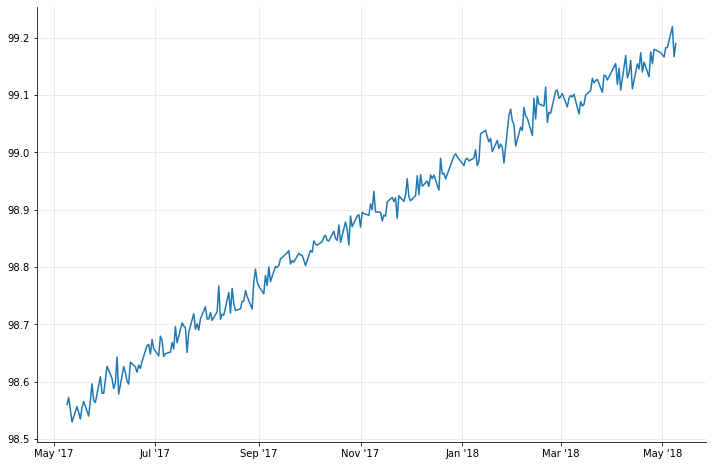

In [15]:
fig, ax = utils.plot()
ax.xaxis.set_major_formatter(utils.date_formatter())
ax.plot_date([ utils.to_datetime(d) for d in dates ], values,'-');

#### Using quotes

If we work with quotes, we can also avoid rebuilding the curve.  Let's say our discount curve is defined as a risk-free curve with an additional credit spread.  The risk-free curve is bootstrapped from a number of market rates; for simplicity, here I'll use a set of overnight interest-rate swaps, but you'll use whatever makes sense in your case.

In [18]:
index = ql.Eonia()
tenors = [ ql.Period(i, ql.Years) for i in range(1,11) ]
rates = [ 0.010, 0.012, 0.013, 0.014, 0.016,
          0.017, 0.018, 0.020, 0.021, 0.022 ]

quotes = []
helpers = []
for tenor, rate in zip(tenors, rates):
    q = ql.SimpleQuote(rate)
    h = ql.OISRateHelper(2, tenor, ql.QuoteHandle(q), index)
    quotes.append(q)
    helpers.append(h)

One thing to note: I'll setup the curve so that it moves with the evaluation date.  This means that I won't pass an explicit reference date, but a number of business days and a calendar.  Passing 0, as in this case, will cause the reference date of the curve to equal the evaluation date; passing 2, for instance, would cause it to equal the corresponding spot date.

In [19]:
risk_free_curve = ql.PiecewiseFlatForward(0, ql.TARGET(),
                                          helpers, ql.Actual360())

Finally, I'll manage credit as an additional spread over the curve:

In [20]:
spread = ql.SimpleQuote(0.01)
discount_curve = ql.ZeroSpreadedTermStructure(
    ql.YieldTermStructureHandle(risk_free_curve),
    ql.QuoteHandle(spread))

Now we can recalculate today's price...

In [21]:
prices = {}

ql.Settings.instance().evaluationDate = today
discount_handle.linkTo(discount_curve)

prices[today] = bond.cleanPrice()
print(prices[today])

96.50362161659807


...and as before, we go back; except this time we don't need to build a new curve.  Instead, we can set new values to the quotes and they will trigger the necessary recalculations.

In [22]:
date = calendar.advance(today, -1, ql.Days)

base_rates = np.array(rates)

while date >= first_date:
    rates = base_rates * np.random.normal(loc=1.0, scale=0.005,
                                          size=base_rates.shape)
    for q, r in zip(quotes, rates):
        q.setValue(r)
    spread.setValue(spread.value()*np.random.normal(loc=1.0, scale=0.005))

    ql.Settings.instance().evaluationDate = date

    prices[date] = bond.cleanPrice()
    date = calendar.advance(date, -1, ql.Days)

Note that we didn't create any new object in the loop; we're only settings new values to the quotes.

Again, here are the results:

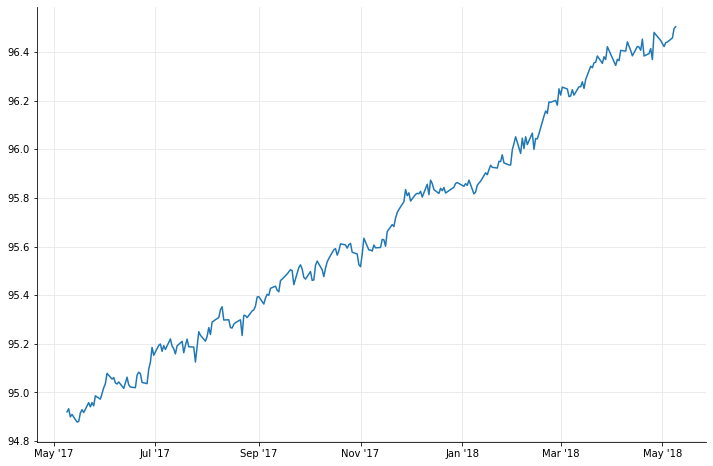

In [23]:
dates, values = zip(*sorted(prices.items()))

fig, ax = utils.plot()
ax.xaxis.set_major_formatter(utils.date_formatter())
ax.plot_date([ utils.to_datetime(d) for d in dates ], values,'-');

#### A complication: past fixings

For instruments that depend on the floating rate, we might need some past fixings.  This is not necessarily related to pricing on a range of dates: even on today's date, we need the fixing for the current coupon.  Let's set the instrument up...

In [24]:
forecast_handle = ql.YieldTermStructureHandle(risk_free_curve)
index = ql.Euribor6M(forecast_handle)

bond = ql.FloatingRateBond(3, 100, schedule, index, ql.Thirty360())
bond.setPricingEngine(ql.DiscountingBondEngine(discount_handle))

In [25]:
ql.Settings.instance().evaluationDate = today
for q, r in zip(quotes, base_rates):
    q.setValue(r)
spread.setValue(0.01)

...and try to price it.  No joy.

In [26]:
print(bond.cleanPrice())

RuntimeError: Missing Euribor6M Actual/360 fixing for February 6th, 2018

Being in the past, the fixing can't be retrieved from the curve.  We have to store it into the index, after which the calculation works:

In [27]:
index.addFixing(ql.Date(6, ql.February,2018), 0.005)

print(bond.cleanPrice())

97.11939323923686


When pricing on a range of dates, though, we need to take into account the fact that the current coupon changes as we go back in time.  These two dates will work...

In [26]:
ql.Settings.instance().evaluationDate = ql.Date(1, ql.March, 2018)
print(bond.cleanPrice())

ql.Settings.instance().evaluationDate = ql.Date(15, ql.February, 2018)
print(bond.cleanPrice())

96.84331874622794
96.79054303973298


...but this one causes the previous coupon to be evaluated, and that requires a new fixing:

In [27]:
ql.Settings.instance().evaluationDate = ql.Date(1, ql.February, 2018)
print(bond.cleanPrice())

RuntimeError: Missing Euribor6M Actual/360 fixing for August 4th, 2017

Once we add it, the calculation works again.

In [28]:
index.addFixing(ql.Date(4, ql.August, 2017), 0.004)
print(bond.cleanPrice())

96.98060241422583


(If you're wondering how the calculation worked before, since this coupon belonged to the bond: on the other evaluation dates, this coupon was expired and the engine could skip it without needing to calculate its amount.  Thus, its fixing didn't need to be retrieved.)

#### More complications: future prices

What if we go forward in time, instead of pricing on past dates?

For one thing, we'll need to forecast curves in some way.  One way is to imply them from today's curves: I talk about implied curves in another notebook, so I won't repeat myself here.  Let's assume we have implied rates and we can set them.  Once we do, we can price in the future just as easily as we do in the past.  As I write this, it's May 19th 2018, and June 1st is in the future:

In [29]:
ql.Settings.instance().evaluationDate = ql.Date(1, ql.June, 2018)

print(bond.cleanPrice())

97.2126812565699


However, there's another problem, as pointed out by [Mariano Zeron](https://sourceforge.net/p/quantlib/mailman/message/35270917/) in a post to the QuantLib mailing list.  If we go further in the future,  the bond will require&mdash;so to speak&mdash;future past fixings.

In [30]:
ql.Settings.instance().evaluationDate = ql.Date(1, ql.June, 2019)

print(bond.cleanPrice())

RuntimeError: Missing Euribor6M Actual/360 fixing for February 6th, 2019

Here the curve starts on June 1st 2019, and cannot retrieve the fixing at the start of the corresponding coupon.

One way out of this might be to forecast fixings off the current curve and store them:

In [31]:
ql.Settings.instance().evaluationDate = ql.Date(1, ql.June, 2018)

future_fixing = index.fixing(ql.Date(6,ql.February,2019))
print(future_fixing)
index.addFixing(ql.Date(6,ql.February,2019), future_fixing)

0.011387399107860378


This way, they will be retrieved in the same way as real past fixings.

In [32]:
ql.Settings.instance().evaluationDate = ql.Date(1, ql.June, 2019)

print(bond.cleanPrice())

98.30830224923507


Of course, you might forecast them in a better way: that's up to you.  And if you're worried that this might interfere with pricing on today's date, don't: stored fixings are only used if they're in the past with respect to the evaluation date.  The fixing I'm storing below for February 3rd 2021 will be retrieved if the evaluation date is later...

In [33]:
index.addFixing(ql.Date(3,ql.February,2021), 0.02)

ql.Settings.instance().evaluationDate = ql.Date(1, ql.June, 2021)
print(index.fixing(ql.Date(3,ql.February,2021)))

0.02


...but it will be forecast from the curve when it's after the evaluation date:

In [34]:
ql.Settings.instance().evaluationDate = ql.Date(1, ql.June, 2020)
print(index.fixing(ql.Date(3,ql.February,2021)))

0.011367299732914539
